In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import bayesnet as bn

np.random.seed(1234)

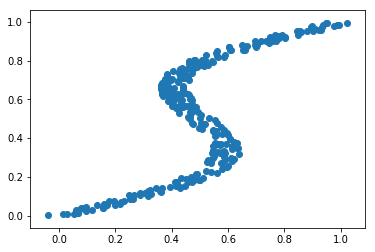

In [2]:
def func(x):
    return x + 0.3 * np.sin(2 * np.pi * x)

def sample(x, y, n=None):
    assert len(x) == len(y)
    N = len(x)
    if n is None:
        n = N
    indices = np.random.choice(N, n, replace=False)
    return x[indices], y[indices]

y_train = np.random.uniform(size=(300, 1))
x_train = func(y_train) + np.random.uniform(-0.05, 0.05, size=y_train.shape)

plt.scatter(x_train, y_train)

In [3]:
class MixtureDensityNetwork(bn.Network):
    
    def __init__(self, n_input, n_hidden, n_component=3):
        super().__init__(
            w1=np.random.randn(n_input, n_hidden),
            b1=np.zeros(n_hidden),
            w2_coef=np.random.randn(n_hidden, n_component),
            b2_coef=np.zeros(n_component),
            w2_mu=np.random.randn(n_hidden, n_component),
            b2_mu=np.zeros(n_component),
            w2_s=np.random.randn(n_hidden, n_component),
            b2_s=np.zeros(n_component)
        )

    def __call__(self, x, y=None):
        h = bn.tanh(x @ self.w1 + self.b1)
        coef = bn.softmax(h @ self.w2_coef + self.b2_coef)
        mu = h @ self.w2_mu + self.b2_mu
        std = bn.softplus(h @ self.w2_s + self.b2_s)
        self.y = bn.random.GaussianMixture(coef, mu, std, data=y)
        return self.y.pdf().value

In [4]:
model = MixtureDensityNetwork(1, 5)
optimizer = bn.optimizer.Adam(model, 1e-4)
history = []

for _ in range(50000):
    model.cleargrad()
    batch = sample(x_train, y_train, n=100)
    model(*batch)
    log_likelihood = model.elbo()
    log_likelihood.backward()
    history.append(log_likelihood.value)
    optimizer.update()

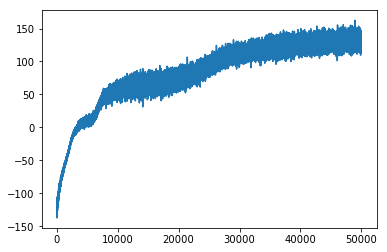

In [5]:
plt.plot(history)

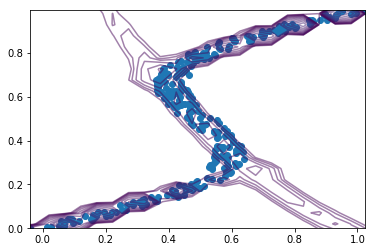

In [6]:
xy_grid = np.mgrid[-2:3:100j, -2:3:100j]
x, y = xy_grid[0], xy_grid[1]

plt.scatter(x_train, y_train)
prob = model(x.reshape(-1, 1), y.reshape(-1, 1)).reshape(100, 100)
levels_log = np.linspace(0, np.log(prob.max()), 21)
levels = np.exp(levels_log)
levels[0] = 0
plt.contour(x, y, prob, levels, alpha=0.5)
plt.xlim(x_train.min(), x_train.max())
plt.ylim(y_train.min(), y_train.max())
plt.show()